# Prep Data

Create a data table showing voter turnout rate by county for the 2016 Presidential election

In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Total Votes by county

The data was scraped from https://www.townhall.com/election/2016/president/  

Found a github repo where much of this scraping has been done already: https://github.com/tonmcg/US_County_Level_Election_Results_08-16

In [2]:
file_url = 'https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-16/master/2016_US_County_Level_Presidential_Results.csv'
votes_df = pd.read_csv(file_url)

In [3]:
votes_df.head()

,Unnamed: 0,votes_dem,votes_gop,total_votes,per_dem,per_gop,diff,per_point_diff,state_abbr,county_name,combined_fips
0,0,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2013
1,1,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2016
2,2,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2020
3,3,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2050
4,4,93003.0,130413.0,246588.0,0.377159,0.52887,"37,410",15.17%,AK,Alaska,2060


In [4]:
votes_df = votes_df[['total_votes', 'state_abbr', 'county_name', 'combined_fips']]

In [5]:
votes_df.rename(columns={'total_votes': 'totalVotes', 'combined_fips': 'FIPS'}, inplace=True)

In [6]:
votes_df['FIPS'] = votes_df['FIPS'].apply(lambda x: str(x).zfill(5))

In [7]:
votes_df.tail()

,totalVotes,state_abbr,county_name,FIPS
3136,16661.0,WY,Sweetwater County,56037
3137,12176.0,WY,Teton County,56039
3138,8053.0,WY,Uinta County,56041
3139,3715.0,WY,Washakie County,56043
3140,3334.0,WY,Weston County,56045


In [8]:
votes_df.shape

(3141, 4)

# Voting Age Population by county

County level data from US Census, 2012-2016 American Community Survey 5 year estimates https://www.census.gov/programs-surveys/decennial-census/about/voting-rights/cvap.2016.html

**Note:** had to download, and resave the County.csv file with encoding as utf-8 

In [9]:
ls data/raw

ACS_CVAP_County.csv  usCounties.csv


In [10]:
vap_df = pd.read_csv('data/raw/ACS_CVAP_County.csv')

In [11]:
vap_df.head()

,GEONAME,LNTITLE,GEOID,LNNUMBER,TOT_EST,TOT_MOE,ADU_EST,ADU_MOE,CIT_EST,CIT_MOE,CVAP_EST,CVAP_MOE
0,"Autauga County, Alabama",Total,05000US01001,1,55050,NaN,41195,34.0,54510,263,40690,236
1,"Autauga County, Alabama",Not Hispanic or Latino,05000US01001,2,53635,NaN,40290,35.0,53325,220,40015,184
2,"Autauga County, Alabama",American Indian or Alaska Native Alone,05000US01001,3,225,74.0,125,55.0,225,74,125,55
3,"Autauga County, Alabama",Asian Alone,05000US01001,4,485,165.0,390,106.0,340,200,245,161
4,"Autauga County, Alabama",Black or African American Alone,05000US01001,5,10115,242.0,7470,75.0,10115,242,7470,75


We want only the **TOTAL** rows

In [12]:
vap_df = vap_df[vap_df['LNNUMBER'] == 1]  # LNNUMBER = 1 is code for LNTITLE = Total

In [13]:
vap_df.shape

(3220, 12)

In [14]:
vap_df = vap_df[['GEONAME', 'GEOID', 'CVAP_EST', 'CVAP_MOE']]

In [15]:
vap_df.rename(
    columns = {
        'GEOID': 'FIPS',
        'CVAP_EST': 'VAP', 
        'CVAP_MOE':'VAP_MOE'}, 
    inplace=True)


In [16]:
vap_df['FIPS'] = vap_df['FIPS'].apply(lambda x: x[-5:])

In [17]:
vap_df

,GEONAME,FIPS,VAP,VAP_MOE
0,"Autauga County, Alabama",01001,40690,236
13,"Baldwin County, Alabama",01003,151770,680
26,"Barbour County, Alabama",01005,20375,113
39,"Bibb County, Alabama",01007,17590,81
52,"Blount County, Alabama",01009,42430,314
...,...,...,...,...
41795,"Vega Baja Municipio, Puerto Rico",72145,43335,90
41808,"Vieques Municipio, Puerto Rico",72147,7075,16
41821,"Villalba Municipio, Puerto Rico",72149,18270,52
41834,"Yabucoa Municipio, Puerto Rico",72151,27785,44


# Master list of all Counties

In [18]:
counties_df = pd.read_csv('data/raw/usCounties.csv')

In [19]:
counties_df.head()

,stateAbbrev,stateFIPS,countyFIPS,countyName,huh
0,AL,1,1,Autauga County,H1
1,AL,1,3,Baldwin County,H1
2,AL,1,5,Barbour County,H1
3,AL,1,7,Bibb County,H1
4,AL,1,9,Blount County,H1


In [20]:
def combineFIPS(row):
    state = str(row['stateFIPS']).zfill(2)
    county = str(row['countyFIPS']).zfill(3)
    
    return '{}{}'.format(state,county)

In [21]:
counties_df['FIPS'] = counties_df.apply(combineFIPS, axis=1)

In [22]:
counties_df = counties_df[['stateAbbrev', 'countyName', 'FIPS']]

In [23]:
counties_df.head()

,stateAbbrev,countyName,FIPS
0,AL,Autauga County,01001
1,AL,Baldwin County,01003
2,AL,Barbour County,01005
3,AL,Bibb County,01007
4,AL,Blount County,01009


In [24]:
counties_df.shape

(3235, 3)

# Combine

combined the vote tallies and vap for each county in the master county list

### total votes

In [25]:
df = counties_df.merge(votes_df[['totalVotes', 'FIPS']], how='left', on='FIPS')

In [26]:
df.head()

,stateAbbrev,countyName,FIPS,totalVotes
0,AL,Autauga County,01001,24661.0
1,AL,Baldwin County,01003,94090.0
2,AL,Barbour County,01005,10390.0
3,AL,Bibb County,01007,8748.0
4,AL,Blount County,01009,25384.0


In [27]:
df['totalVotes'].isnull().sum()

94

## VAP

In [28]:
df = df.merge(vap_df[['VAP', 'FIPS']], how='left', on='FIPS')

In [29]:
df.head()

,stateAbbrev,countyName,FIPS,totalVotes,VAP
0,AL,Autauga County,01001,24661.0,40690.0
1,AL,Baldwin County,01003,94090.0,151770.0
2,AL,Barbour County,01005,10390.0,20375.0
3,AL,Bibb County,01007,8748.0,17590.0
4,AL,Blount County,01009,25384.0,42430.0


In [30]:
df['VAP'].isnull().sum()

17

# Calculate Voter Turnout Rates

In [31]:
def turnout(row):
    votes = row['totalVotes']
    vap = row['VAP']
    
    return votes/vap * 100

In [32]:
df['turnoutPerc'] = df.apply(turnout, axis=1)

In [33]:
df.head()

,stateAbbrev,countyName,FIPS,totalVotes,VAP,turnoutPerc
0,AL,Autauga County,01001,24661.0,40690.0,60.607029
1,AL,Baldwin County,01003,94090.0,151770.0,61.995124
2,AL,Barbour County,01005,10390.0,20375.0,50.993865
3,AL,Bibb County,01007,8748.0,17590.0,49.732803
4,AL,Blount County,01009,25384.0,42430.0,59.825595


In [35]:
# calculate non voters
df['nNonVote'] = df['VAP'] - df['totalVotes']

In [36]:
df.head()

,stateAbbrev,countyName,FIPS,totalVotes,VAP,turnoutPerc,nNonVote
0,AL,Autauga County,01001,24661.0,40690.0,60.607029,16029.0
1,AL,Baldwin County,01003,94090.0,151770.0,61.995124,57680.0
2,AL,Barbour County,01005,10390.0,20375.0,50.993865,9985.0
3,AL,Bibb County,01007,8748.0,17590.0,49.732803,8842.0
4,AL,Blount County,01009,25384.0,42430.0,59.825595,17046.0


# summary of data

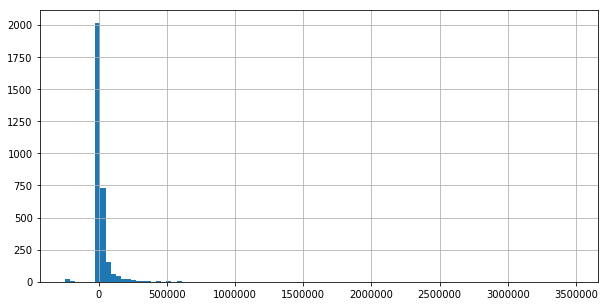

In [41]:
plt.figure(figsize=(10,5))
df['nNonVote'].hist(bins=100)

In [42]:
df['nNonVote'].max()

3471418.0

In [51]:
df.loc[df['nNonVote'].argmax()]

stateAbbrev                    CA
countyName     Los Angeles County
FIPS                        06037
totalVotes            2.65207e+06
VAP                   6.12349e+06
turnoutPerc               43.3098
nNonVote              3.47142e+06
Name: 204, dtype: object

# Write out data

In [53]:
df.to_csv('data/voterTurnout.csv', index=False)